# Sea surface currents (SSC) prediction from Himawari-8/9 SST 

Using the Gaussian Process method of de Kreij et al., 2025.

### In this tutorial:
1. Download and preprocess Himawari-8/9 SST data
2. View the SST data and spatial and temporal gradients
3. Perform Gaussian Process regression and inspect the hyper-parameter results
4. View the surface current predictions and uncertainties

Only a single prediction time step is shwon in this tutorial. To process many time steps see tutorial 3. 

In [1]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from inversion_sst_gp import plots
from inversion_sst_gp import gp_regression as gpr
from inversion_sst_gp.download import himawari
from inversion_sst_gp import utils

%matplotlib inline

/home/wedge/anaconda3/envs/sstinv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Download himawari data

##### Set geographical limits and chose a time step

*Note that ~3 x 3 degree boxes are a recommended maximum area for reasonable processing on personal computers.*

In [2]:
# Define geographical and temporal boundaries for data processing
LON_LIMITS = (122.5, 123.75)
LAT_LIMITS = (-14.3, -13.3)  
ll_box = (LON_LIMITS, LAT_LIMITS)

# Set the time bounds - predictions will be done hourly within these limits
time_lims = ["2023-06-01T00:00:00", "2023-07-03T00:00:00"]

crop_app = 'browse_basin_june23'

# # Set the save directory for the data (recommend this directory is ignored by git if inside the repo)
# alldata_dir = os.path.join('/mnt', 'share', 'Other', 'Himawari', 'all')
# cropped_dir = os.path.join('/mnt', 'share', 'Other', 'Himawari', 'browse')
base_dir = os.path.join('/mnt', 'd', 'Work_backup', 'C_drive', 'Large_Data')
alldata_dir = os.path.join(base_dir, 'Other', 'Himawari', 'all')
cropped_dir = os.path.join(base_dir, 'Other', 'Himawari', crop_app)

##### Retrieve the required complete Himawari data files

Some files don't exist on the server. These timesteps will not get a velocity prediction.

In [ ]:
# Download the data
himawari.get_sst_series_nasa(time_lims, alldata_dir)

EarthAccess authenticated: True


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 985.97it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.34s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13066.37it/s]


Downloaded and verified: 20230531230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1010.68it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.34s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16448.25it/s]


Downloaded and verified: 20230601000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1934.64it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.12s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 10131.17it/s]


Downloaded and verified: 20230601010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1093.98it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.92s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12483.05it/s]


Downloaded and verified: 20230601020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 669.16it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.72s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12595.51it/s]


Downloaded and verified: 20230601030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1462.96it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.52s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9754.20it/s]


Downloaded and verified: 20230601040000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1469.11it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.57s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12748.64it/s]


Downloaded and verified: 20230601050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1145.05it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.19s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16513.01it/s]


Downloaded and verified: 20230601060000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1371.58it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13751.82it/s]


Downloaded and verified: 20230601070000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2247.75it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.13s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14665.40it/s]


Downloaded and verified: 20230601080000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1435.91it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16912.52it/s]


Downloaded and verified: 20230601090000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2163.13it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 4650.00it/s]


Downloaded and verified: 20230601100000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 544.22it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.26s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12192.74it/s]


Downloaded and verified: 20230601110000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1613.19it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.36s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13573.80it/s]


Downloaded and verified: 20230601120000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1825.99it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.38s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15420.24it/s]


Downloaded and verified: 20230601130000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1643.54it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:05<00:00,  5.99s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12595.51it/s]


Downloaded and verified: 20230601140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1218.57it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9020.01it/s]


Downloaded and verified: 20230601150000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1516.93it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17924.38it/s]


Downloaded and verified: 20230601160000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1572.08it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.45s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 10979.85it/s]


Downloaded and verified: 20230601170000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1202.15it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:05<00:00,  5.99s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 8811.56it/s]


Downloaded and verified: 20230601180000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1274.86it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.03s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15887.52it/s]


Downloaded and verified: 20230601190000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1705.69it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.49s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14122.24it/s]


Downloaded and verified: 20230601200000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1394.85it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.17s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13148.29it/s]


Downloaded and verified: 20230601210000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1374.28it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.18s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13662.23it/s]


Downloaded and verified: 20230601220000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1215.39it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:11<00:00, 11.11s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14364.05it/s]


Downloaded and verified: 20230601230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1621.93it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.47s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]


Downloaded and verified: 20230602000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2013.59it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.14s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 11491.24it/s]


Downloaded and verified: 20230602010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 756.14it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12052.60it/s]


Downloaded and verified: 20230602020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1421.32it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.70s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15947.92it/s]


Downloaded and verified: 20230602030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1127.20it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.26s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17050.02it/s]


Downloaded and verified: 20230602040000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1925.76it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.44s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 8525.01it/s]


Downloaded and verified: 20230602050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 782.52it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.28s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 6574.14it/s]


Downloaded and verified: 20230602060000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1531.89it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.48s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13025.79it/s]


Downloaded and verified: 20230602070000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1227.48it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 11008.67it/s]


Downloaded and verified: 20230602080000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1076.29it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17050.02it/s]


Downloaded and verified: 20230602090000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1069.16it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.56s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14513.16it/s]


Downloaded and verified: 20230602100000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1864.14it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.38s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18558.87it/s]


Downloaded and verified: 20230602110000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1529.09it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.23s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14820.86it/s]


Downloaded and verified: 20230602120000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1049.63it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15307.68it/s]


Downloaded and verified: 20230602130000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1522.43it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.70s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16777.22it/s]


Downloaded and verified: 20230602140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1453.33it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14614.30it/s]


Downloaded and verified: 20230602150000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1190.55it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16256.99it/s]


Downloaded and verified: 20230602160000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1213.63it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.12s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14614.30it/s]


Downloaded and verified: 20230602170000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1816.50it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.08s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12336.19it/s]


Downloaded and verified: 20230602180000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1400.90it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.39s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12520.31it/s]


Downloaded and verified: 20230602190000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1105.22it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:05<00:00,  5.95s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 11096.04it/s]


Downloaded and verified: 20230602200000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 723.28it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.00s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14122.24it/s]


Downloaded and verified: 20230602210000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1449.81it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14266.34it/s]


Downloaded and verified: 20230602220000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2000.14it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.01s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18078.90it/s]


Downloaded and verified: 20230602230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1596.61it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15033.35it/s]


Downloaded and verified: 20230603000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1993.49it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.21s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16256.99it/s]


Downloaded and verified: 20230603010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2175.47it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17623.13it/s]


Downloaded and verified: 20230603020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1692.62it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.28s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13148.29it/s]


Downloaded and verified: 20230603030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1164.11it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17772.47it/s]


Downloaded and verified: 20230603040000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1803.23it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.36s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13751.82it/s]


Downloaded and verified: 20230603050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1158.01it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.59s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16578.28it/s]


Downloaded and verified: 20230603060000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1450.81it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.18s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]


Downloaded and verified: 20230603070000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1599.05it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16644.06it/s]


Downloaded and verified: 20230603080000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1117.29it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.39s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14315.03it/s]


Downloaded and verified: 20230603090000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1248.30it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.50s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14027.77it/s]


Downloaded and verified: 20230603100000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 910.42it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.24s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9962.72it/s]


Downloaded and verified: 20230603110000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 999.83it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.17s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9300.01it/s]


Downloaded and verified: 20230603120000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1231.45it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.04s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 11155.06it/s]


Downloaded and verified: 20230603130000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1482.61it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.09s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14979.66it/s]


Downloaded and verified: 20230603140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1608.25it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.21s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14463.12it/s]


Downloaded and verified: 20230603150000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1583.35it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.09s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]


Downloaded and verified: 20230603160000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1156.41it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.51s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12633.45it/s]


Downloaded and verified: 20230603170000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1129.02it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14563.56it/s]


Downloaded and verified: 20230603180000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1818.08it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.01s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13530.01it/s]


Downloaded and verified: 20230603190000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2145.42it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15534.46it/s]


Downloaded and verified: 20230603200000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 954.34it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.13s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13107.20it/s]


Downloaded and verified: 20230603210000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1099.42it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 10459.61it/s]


Downloaded and verified: 20230603220000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1150.39it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.18s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13981.01it/s]


Downloaded and verified: 20230603230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1221.05it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.55s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9446.63it/s]


Downloaded and verified: 20230604000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1326.47it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.45s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13486.51it/s]


Downloaded and verified: 20230604010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1131.46it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.43s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 10407.70it/s]


Downloaded and verified: 20230604020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1118.18it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.57s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 11618.57it/s]


Downloaded and verified: 20230604030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1903.04it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15033.35it/s]


Downloaded and verified: 20230604040000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1401.37it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.39s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14614.30it/s]


Downloaded and verified: 20230604050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 876.00it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.45s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 7436.71it/s]


Downloaded and verified: 20230604060000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1514.74it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.49s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 11881.88it/s]


Downloaded and verified: 20230604070000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1676.38it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.46s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12710.01it/s]


Downloaded and verified: 20230604080000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1282.66it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.26s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13189.64it/s]


Downloaded and verified: 20230604090000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1151.96it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.23s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15827.56it/s]


Downloaded and verified: 20230604100000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1495.30it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.34s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 10131.17it/s]


Downloaded and verified: 20230604110000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1322.29it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.38s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]


Downloaded and verified: 20230604120000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2344.50it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.31s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17050.02it/s]


Downloaded and verified: 20230604130000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1625.70it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.12s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 10922.67it/s]


Downloaded and verified: 20230604140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1289.36it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.15s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 10381.94it/s]


Downloaded and verified: 20230604150000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 705.99it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.44s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 6636.56it/s]


Downloaded and verified: 20230604160000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 945.51it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.01s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 11305.40it/s]


Downloaded and verified: 20230604170000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 831.21it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.47s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9341.43it/s]


Downloaded and verified: 20230604180000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1102.02it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.05s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16194.22it/s]


Downloaded and verified: 20230604190000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1548.86it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:05<00:00,  5.98s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]


Downloaded and verified: 20230604200000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1500.65it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:05<00:00,  5.84s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13662.23it/s]


Downloaded and verified: 20230604210000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1154.18it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.57s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13066.37it/s]


Downloaded and verified: 20230604220000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1395.78it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:05<00:00,  5.97s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 8065.97it/s]


Downloaded and verified: 20230604230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1285.02it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.10s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15709.00it/s]


Downloaded and verified: 20230605000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1294.14it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17924.38it/s]


Downloaded and verified: 20230605010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1216.80it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.16s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13357.66it/s]


Downloaded and verified: 20230605020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1402.78it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.32s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18078.90it/s]


Downloaded and verified: 20230605030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1951.75it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.08s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13706.88it/s]


Downloaded and verified: 20230605040000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1161.21it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16256.99it/s]


Downloaded and verified: 20230605050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2132.34it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.53s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]


Downloaded and verified: 20230605060000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1992.54it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.21s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 10782.27it/s]


Downloaded and verified: 20230605070000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 904.72it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:07<00:00,  7.03s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17260.51it/s]


Downloaded and verified: 20230605080000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 940.43it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.28s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16320.25it/s]


Downloaded and verified: 20230605090000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1299.75it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.42s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14413.42it/s]


Downloaded and verified: 20230605100000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1179.83it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.28s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16578.28it/s]


Downloaded and verified: 20230605110000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1082.12it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.45s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 6114.15it/s]


Downloaded and verified: 20230605120000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1098.27it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.47s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16070.13it/s]


Downloaded and verified: 20230605130000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1730.32it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13530.01it/s]


Downloaded and verified: 20230605140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1278.75it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.12s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16320.25it/s]


Downloaded and verified: 20230605150000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1157.05it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.23s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16777.22it/s]


Downloaded and verified: 20230605160000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1598.44it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.10s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 8943.08it/s]


Downloaded and verified: 20230605170000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1164.11it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9619.96it/s]


Downloaded and verified: 20230605180000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1586.95it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.13s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9404.27it/s]


Downloaded and verified: 20230605190000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1551.72it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.19s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14169.95it/s]


Downloaded and verified: 20230605200000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1122.97it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.34s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 7898.88it/s]


Downloaded and verified: 20230605210000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1635.84it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.10s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 10672.53it/s]


Downloaded and verified: 20230605220000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1400.90it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.37s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 11037.64it/s]


Downloaded and verified: 20230605230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1698.10it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12633.45it/s]


Downloaded and verified: 20230606000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1218.57it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.48s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13315.25it/s]


Downloaded and verified: 20230606010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1091.13it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.36s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16912.52it/s]


Downloaded and verified: 20230606020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1532.45it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.43s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16008.79it/s]


Downloaded and verified: 20230606030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1596.01it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.44s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16912.52it/s]


Downloaded and verified: 20230606040000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1501.18it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17403.75it/s]


Downloaded and verified: 20230606050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1206.65it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.48s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14364.05it/s]


Downloaded and verified: 20230606060000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1518.57it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.43s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 10565.00it/s]


Downloaded and verified: 20230606070000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1089.15it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.43s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14217.98it/s]


Downloaded and verified: 20230606080000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1416.99it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14768.68it/s]


Downloaded and verified: 20230606090000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1595.40it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16844.59it/s]


Downloaded and verified: 20230606100000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1107.26it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.31s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16912.52it/s]


Downloaded and verified: 20230606110000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1607.63it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 11748.75it/s]


Downloaded and verified: 20230606120000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1124.18it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.36s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]


Downloaded and verified: 20230606130000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1135.13it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.95s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17403.75it/s]


Downloaded and verified: 20230606140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1981.25it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.64s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]


Downloaded and verified: 20230606150000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1562.12it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14820.86it/s]


Downloaded and verified: 20230606160000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1628.22it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.16s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13443.28it/s]


Downloaded and verified: 20230606170000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1136.05it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.14s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15477.14it/s]


Downloaded and verified: 20230606180000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1103.47it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.05s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15768.06it/s]


Downloaded and verified: 20230606190000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1402.78it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16513.01it/s]


Downloaded and verified: 20230606200000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2145.42it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.72s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]


Downloaded and verified: 20230606210000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1214.68it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.18s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13273.11it/s]


Downloaded and verified: 20230606220000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1719.68it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.35s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 11881.88it/s]


Downloaded and verified: 20230606230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1351.69it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15650.39it/s]


Downloaded and verified: 20230607000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1526.31it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.53s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15033.35it/s]


Downloaded and verified: 20230607010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1635.84it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.35s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13934.56it/s]


Downloaded and verified: 20230607020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1222.12it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12865.96it/s]


Downloaded and verified: 20230607030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1535.81it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.81s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12264.05it/s]


Downloaded and verified: 20230607040000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1001.74it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.63s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 10485.76it/s]


Downloaded and verified: 20230607050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1417.95it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.45s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]


Downloaded and verified: 20230607060000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1362.67it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.31s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]


Downloaded and verified: 20230607070000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1510.37it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.56s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 5504.34it/s]


Downloaded and verified: 20230607080000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 626.20it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16131.94it/s]


Downloaded and verified: 20230607090000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 947.01it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.23s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14513.16it/s]


Downloaded and verified: 20230607100000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1891.03it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.13s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 5974.79it/s]


Downloaded and verified: 20230607110000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 734.81it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.10s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14716.86it/s]


Downloaded and verified: 20230607120000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1594.79it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:07<00:00,  7.10s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16131.94it/s]


Downloaded and verified: 20230607130000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 926.51it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16912.52it/s]


Downloaded and verified: 20230607140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1625.70it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.10s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13706.88it/s]


Downloaded and verified: 20230607150000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 958.04it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.28s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16070.13it/s]


Downloaded and verified: 20230607160000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1271.39it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9279.43it/s]


Downloaded and verified: 20230607170000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 924.47it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.04s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13443.28it/s]


Downloaded and verified: 20230607180000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1670.37it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.15s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15087.42it/s]


Downloaded and verified: 20230607190000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1522.99it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.19s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18641.35it/s]


Downloaded and verified: 20230607200000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1140.38it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.17s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14463.12it/s]


Downloaded and verified: 20230607210000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1237.62it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.13s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]


Downloaded and verified: 20230607220000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1089.43it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.34s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9238.56it/s]


Downloaded and verified: 20230607230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1580.97it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.65s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13443.28it/s]


Downloaded and verified: 20230608000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1664.41it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.41s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14122.24it/s]


Downloaded and verified: 20230608010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1643.54it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.35s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]


Downloaded and verified: 20230608020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1482.61it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.43s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9404.27it/s]


Downloaded and verified: 20230608030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1096.84it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.60s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 6955.73it/s]


Downloaded and verified: 20230608040000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1001.27it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.61s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17119.61it/s]


Downloaded and verified: 20230608050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1391.61it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.93s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14716.86it/s]


Downloaded and verified: 20230608060000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 819.84it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14027.77it/s]


Downloaded and verified: 20230608070000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1558.64it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.47s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18001.30it/s]


Downloaded and verified: 20230608080000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2256.22it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.32s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12409.18it/s]


Downloaded and verified: 20230608090000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1363.11it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:07<00:00,  7.45s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13443.28it/s]


Downloaded and verified: 20230608100000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1167.35it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.35s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]


Downloaded and verified: 20230608110000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2226.28it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 6177.18it/s]


Downloaded and verified: 20230608120000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1305.42it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 10010.27it/s]


Downloaded and verified: 20230608130000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1317.72it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.17s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 10754.63it/s]


Downloaded and verified: 20230608140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1325.63it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.16s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13662.23it/s]


Downloaded and verified: 20230608150000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1182.83it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.37s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12122.27it/s]


Downloaded and verified: 20230608160000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1274.86it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.12s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17119.61it/s]


Downloaded and verified: 20230608170000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1387.92it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 7410.43it/s]


Downloaded and verified: 20230608180000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 897.56it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18236.10it/s]


Downloaded and verified: 20230608190000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1147.55it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17189.77it/s]


Downloaded and verified: 20230608200000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1271.77it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12710.01it/s]


Downloaded and verified: 20230608210000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1429.55it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.39s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17403.75it/s]


Downloaded and verified: 20230608220000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1138.83it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.43s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15947.92it/s]


Downloaded and verified: 20230608230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 844.60it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.49s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14665.40it/s]


Downloaded and verified: 20230609000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2051.00it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.37s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16070.13it/s]


Downloaded and verified: 20230609010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1534.13it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.41s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]


Downloaded and verified: 20230609020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1029.28it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.82s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16912.52it/s]


Downloaded and verified: 20230609030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1479.47it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.40s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17924.38it/s]


Downloaded and verified: 20230609040000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1541.46it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:07<00:00,  7.43s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13066.37it/s]


Downloaded and verified: 20230609050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 940.43it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.60s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]


Downloaded and verified: 20230609060000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1141.62it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.44s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16384.00it/s]


Downloaded and verified: 20230609070000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1633.30it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.39s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16912.52it/s]


Downloaded and verified: 20230609080000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1163.47it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.98s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13107.20it/s]


Downloaded and verified: 20230609090000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1126.59it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.55s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14074.85it/s]


Downloaded and verified: 20230609100000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1503.87it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.49s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]


Downloaded and verified: 20230609110000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2220.38it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.46s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15477.14it/s]


Downloaded and verified: 20230609120000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1577.40it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16256.99it/s]


Downloaded and verified: 20230609130000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2050.00it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.37s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15887.52it/s]


Downloaded and verified: 20230609140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1095.98it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14716.86it/s]


Downloaded and verified: 20230609150000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1141.62it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.40s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9238.56it/s]


Downloaded and verified: 20230609160000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 929.59it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.32s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14614.30it/s]


Downloaded and verified: 20230609170000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1804.78it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13400.33it/s]


Downloaded and verified: 20230609180000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2109.81it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.14s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]


Downloaded and verified: 20230609190000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2110.87it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.58s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16644.06it/s]


Downloaded and verified: 20230609200000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1250.17it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.23s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14463.12it/s]


Downloaded and verified: 20230609210000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2227.46it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16131.94it/s]


Downloaded and verified: 20230609220000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1522.99it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.38s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]


Downloaded and verified: 20230609230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1272.54it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 7294.44it/s]


Downloaded and verified: 20230610000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 825.16it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.35s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16384.00it/s]


Downloaded and verified: 20230610010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1989.71it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.59s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14926.35it/s]


Downloaded and verified: 20230610020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2019.40it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:07<00:00,  7.72s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 5398.07it/s]


Downloaded and verified: 20230610030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1013.12it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.78s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14820.86it/s]


Downloaded and verified: 20230610040000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 663.87it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.70s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16777.22it/s]


Downloaded and verified: 20230610050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1478.95it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.78s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16513.01it/s]


Downloaded and verified: 20230610060000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1797.05it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.41s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]


Downloaded and verified: 20230610070000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1674.37it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.36s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13706.88it/s]


Downloaded and verified: 20230610080000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2071.26it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18641.35it/s]


Downloaded and verified: 20230610090000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1941.81it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.23s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14217.98it/s]


Downloaded and verified: 20230610100000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 875.27it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.41s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13573.80it/s]


Downloaded and verified: 20230610110000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1228.56it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.46s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15650.39it/s]


Downloaded and verified: 20230610120000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1653.25it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.14s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15768.06it/s]


Downloaded and verified: 20230610130000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 851.46it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.36s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 6364.65it/s]


Downloaded and verified: 20230610140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1495.83it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.39s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16256.99it/s]


Downloaded and verified: 20230610150000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1196.32it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.57s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18078.90it/s]


Downloaded and verified: 20230610160000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1492.10it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:07<00:00,  7.66s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14873.42it/s]


Downloaded and verified: 20230610170000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1594.79it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16912.52it/s]


Downloaded and verified: 20230610180000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1592.98it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13934.56it/s]


Downloaded and verified: 20230610190000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1965.47it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.49s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17119.61it/s]


Downloaded and verified: 20230610200000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1205.61it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9709.04it/s]


Downloaded and verified: 20230610210000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1269.85it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16448.25it/s]


Downloaded and verified: 20230610220000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1910.84it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.73s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13530.01it/s]


Downloaded and verified: 20230610230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1476.35it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.24s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]


Downloaded and verified: 20230611000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1891.03it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]


Downloaded and verified: 20230611010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1282.66it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.28s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18315.74it/s]


Downloaded and verified: 20230611020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2091.92it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.81s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15650.39it/s]


Downloaded and verified: 20230611030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1512.01it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:07<00:00,  7.63s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15033.35it/s]


Downloaded and verified: 20230611040000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1159.29it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.31s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14364.05it/s]


Downloaded and verified: 20230611050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 891.84it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.17s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16070.13it/s]


Downloaded and verified: 20230611060000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1565.04it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.28s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]


Downloaded and verified: 20230611070000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1143.80it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18558.87it/s]


Downloaded and verified: 20230611080000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1070.52it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.09s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17697.49it/s]


Downloaded and verified: 20230611090000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1266.78it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.35s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16070.13it/s]


Downloaded and verified: 20230611100000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1583.35it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14513.16it/s]


Downloaded and verified: 20230611110000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1513.64it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.11s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]


Downloaded and verified: 20230611120000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1586.35it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.18s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15141.89it/s]


Downloaded and verified: 20230611130000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2099.25it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.11s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]


Downloaded and verified: 20230611140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1716.16it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.47s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16384.00it/s]


Downloaded and verified: 20230611150000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 992.97it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:05<00:00,  5.97s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18978.75it/s]


Downloaded and verified: 20230611160000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1513.64it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.51s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16384.00it/s]


Downloaded and verified: 20230611170000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2445.66it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.04s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]


Downloaded and verified: 20230611180000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1534.69it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.32s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14217.98it/s]


Downloaded and verified: 20230611190000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2097.15it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.21s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18078.90it/s]


Downloaded and verified: 20230611200000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1253.53it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.48s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]


Downloaded and verified: 20230611210000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1417.95it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.12s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16070.13it/s]


Downloaded and verified: 20230611220000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1291.35it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.71s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]


Downloaded and verified: 20230611230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1496.90it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.21s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16194.22it/s]


Downloaded and verified: 20230612000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1131.15it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.15s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16912.52it/s]


Downloaded and verified: 20230612010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1277.97it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.08s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15827.56it/s]


Downloaded and verified: 20230612020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1367.56it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.57s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17403.75it/s]


Downloaded and verified: 20230612030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1681.76it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14122.24it/s]


Downloaded and verified: 20230612040000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1249.05it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.24s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16644.06it/s]


Downloaded and verified: 20230612050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1326.05it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16578.28it/s]


Downloaded and verified: 20230612060000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1950.84it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.41s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14716.86it/s]


Downloaded and verified: 20230612070000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1360.90it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.26s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15709.00it/s]


Downloaded and verified: 20230612080000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1212.93it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.12s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 7543.71it/s]


Downloaded and verified: 20230612090000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1230.00it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.08s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13662.23it/s]


Downloaded and verified: 20230612100000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1581.56it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]


Downloaded and verified: 20230612110000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1217.50it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.32s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18236.10it/s]


Downloaded and verified: 20230612120000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1608.86it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.11s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13797.05it/s]


Downloaded and verified: 20230612130000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1311.54it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17772.47it/s]


Downloaded and verified: 20230612140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1048.58it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.13s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13751.82it/s]


Downloaded and verified: 20230612150000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.14s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]


Downloaded and verified: 20230612160000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1126.59it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.13s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16513.01it/s]


Downloaded and verified: 20230612170000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1437.39it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 14217.98it/s]


Downloaded and verified: 20230612180000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1015.08it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12157.40it/s]


Downloaded and verified: 20230612190000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1434.93it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.08s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12483.05it/s]


Downloaded and verified: 20230612200000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1446.31it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.08s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15887.52it/s]


Downloaded and verified: 20230612210000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1163.47it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 10131.17it/s]


Downloaded and verified: 20230612220000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1222.47it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.76s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 16070.13it/s]


Downloaded and verified: 20230612230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1867.46it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.11s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15033.35it/s]


Downloaded and verified: 20230613000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1286.99it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.18s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12748.64it/s]


Downloaded and verified: 20230613010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1040.77it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:06<00:00,  6.50s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12905.55it/s]


Downloaded and verified: 20230613020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1209.08it/s]
PROCESSING TASKS | :   0%|          | 0/1 [56:25<?, ?it/s]


: 

In [4]:
# ### Crop himawari files (optional)

# # Setting ow=True will delete the original files after cropping (can also just set file_app='')
# himawari.crop_sst_series_nasa(alldata_dir, time_lims, ll_box, file_app=crop_app, overwrite=False)

In [5]:
# # Move the new files to another folder
# move_files = glob.glob(os.path.join(alldata_dir, f'*{crop_app}.nc'))
# for mf in move_files:
#     f_name = os.path.split(mf)[1]
#     shutil.move(mf, os.path.join(cropped_dir, f_name))

In [6]:
# # Load the data
# ds = himawari.process_sst_series(cropped_dir, time_lims, ll_box, file_app=crop_app)
# ds

In [7]:
### Optional: save joined DS and delete individual cropped files
# ds.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app}_compiled.nc'))
ds = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_compiled.nc')).sel(time=slice(time_lims[0], time_lims[1]))

### Uncomment to delete individual cropped files
# for mf in move_files:
#     f_name = os.path.split(mf)[1]
#     os.remove(os.path.join(cropped_dir, f_name))

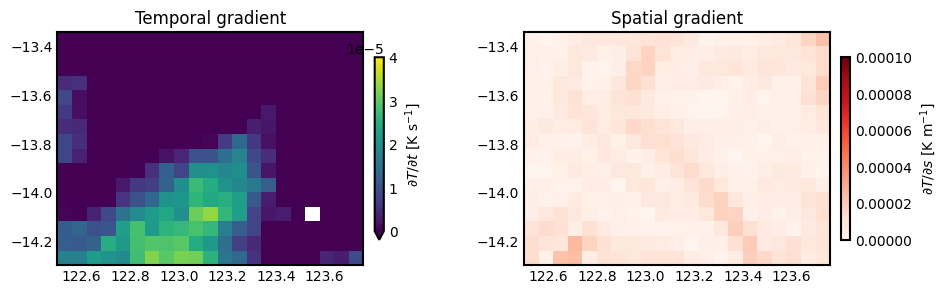

In [8]:
fig, ax = plots.plot_gradients(ds.isel(time=48), sg_names=['dTdx','dTdy'])

In [9]:
# ani = plots.plot_data_animation(ds, anim_interval=200)
# ani.save(f'{crop_app}_data_full.mp4')

---
# Run the parameter optimization

##### Running on the first time step only

This is acceptable for short time series where it is expected that the hyper-parameters do not change significantly over time.

In [10]:
# Set model hyperparameters
prop_sat = gpr.get_default_params()

# Run model
print("Running GP optimization")

# Set the time interval for refitting hyperparameters - if this is less than 1 hr, refitting will occur at every time step
refit_time = np.timedelta64(59, 'm').astype('timedelta64[ns]')

# results_step = gpr.fit_series(ds, prop_sat, refit_time, save_steps=True, save_name=os.path.join(cropped_dir, f'{crop_app}_fits_1h.nc'), callback='off', coverage=0.8)

Running GP optimization


In [11]:
ds_results = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_fits_1h.nc'))
ds_results.close()
ds_results

<xarray.Dataset> Size: 34kB
Dimensions:    (time: 384)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2023-06-17 ... 2023-07-02T23:00:00
Data variables:
    sigma_u    (time) float64 3kB ...
    l_u        (time) float64 3kB ...
    tau_u      (time) float64 3kB ...
    sigma_S    (time) float64 3kB ...
    l_S        (time) float64 3kB ...
    tau_S      (time) float64 3kB ...
    sigma_tau  (time) float64 3kB ...
    l_v        (time) float64 3kB ...
    sigma_v    (time) float64 3kB ...
    tau_v      (time) float64 3kB ...

In [13]:
# print("Calculating GP regression prediction")
# ds_full = gpr.predict_series(ds.sel(time=ds_results.time), ds_results, coverage=0.8)
# ds_full.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app}_predictions_1h.nc'))
ds_full = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_predictions_1h.nc'))

In [14]:
# Assuming `ds` is your xarray dataset
def clean_dataset(ds):
    # Calculate the difference along the time dimension
    diff = ds.diff(dim='time')
    
    # Identify time steps where all variables are zero (repeated time steps)
    repeated_time_steps = (diff == 0).to_array().all(dim='variable').shift(time=1, fill_value=False)
    
    # Drop repeated time steps
    ds = ds.where(~repeated_time_steps, drop=True)
    return ds

def make_even_hourly(ds, time_dim='time'):
    """
    Make the time coordinate of an xarray dataset evenly spaced hourly and fill missing steps with NaN.

    Parameters:
    - ds: xarray.Dataset
        The input dataset with a time coordinate.
    - time_dim: str
        The name of the time dimension (default is 'time').

    Returns:
    - xarray.Dataset
        The dataset with an even hourly time coordinate and NaN for missing steps.
    """
    # Ensure the time coordinate is a pandas datetime index
    time_index = pd.to_datetime(ds[time_dim].values)
    
    # Create an evenly spaced hourly time index
    even_time_index = pd.date_range(start=time_index.min(), end=time_index.max(), freq='h')
    
    # Reindex the dataset to the new time index, filling missing steps with NaN
    ds_even = ds.reindex({time_dim: even_time_index})
    
    return ds_even

def compute_good_data_over_time(ds, variable_name):
    """
    Compute the amount of good data (non-NaN values) for a variable along all
    dimensions except 'time', output as a function of time.

    Parameters:
    - ds: xarray.Dataset
        The input dataset.
    - variable_name: str
        The name of the variable to compute the good data for.

    Returns:
    - xarray.DataArray
        A DataArray with the amount of good data as a function of time.
    """
    # Select the variable
    data = ds[variable_name]
    
    # Count non-NaN values along all dimensions except 'time'
    good_data_count = data.notnull().sum(dim=[dim for dim in data.dims if dim != 'time'])
    
    full_data_count = np.prod([data.sizes[dim] for dim in data.dims if dim != 'time'])
    
    return good_data_count / full_data_count

In [15]:
ds_restrim = ds_results.copy()
ds_restrim = ds_restrim.dropna(dim='time')
ds_restrim = clean_dataset(ds_restrim)
ds_restrim

<xarray.Dataset> Size: 18kB
Dimensions:    (time: 207)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2023-06-17T01:00:00 ... 2023-07-02T2...
Data variables:
    sigma_u    (time) float64 2kB 0.1138 0.1111 0.09666 ... 0.0898 0.09021
    l_u        (time) float64 2kB 2.763e+04 2.704e+04 ... 3.003e+04 2.997e+04
    tau_u      (time) float64 2kB 0.01002 0.01002 0.01002 ... 0.01 0.01 0.01
    sigma_S    (time) float64 2kB 5.184e-06 5.706e-06 ... 5.37e-06 1.01e-05
    l_S        (time) float64 2kB 1.898e+04 2.312e+04 ... 9.538e+03 1.311e+04
    tau_S      (time) float64 2kB 3.071e-07 3.053e-07 ... 2.707e-07 8.516e-08
    sigma_tau  (time) float64 2kB 0.00463 0.004949 ... 0.01035 6.382e-09
    l_v        (time) float64 2kB 2.763e+04 2.704e+04 ... 3.003e+04 2.997e+04
    sigma_v    (time) float64 2kB 0.1138 0.1111 0.09666 ... 0.0898 0.09021
    tau_v      (time) float64 2kB 0.01002 0.01002 0.01002 ... 0.01 0.01 0.01

In [16]:
# If you prefer to have nan instead of missing time steps
ds_full_hourly = make_even_hourly(ds_full)
ds_restrim_hourly = make_even_hourly(ds_restrim)

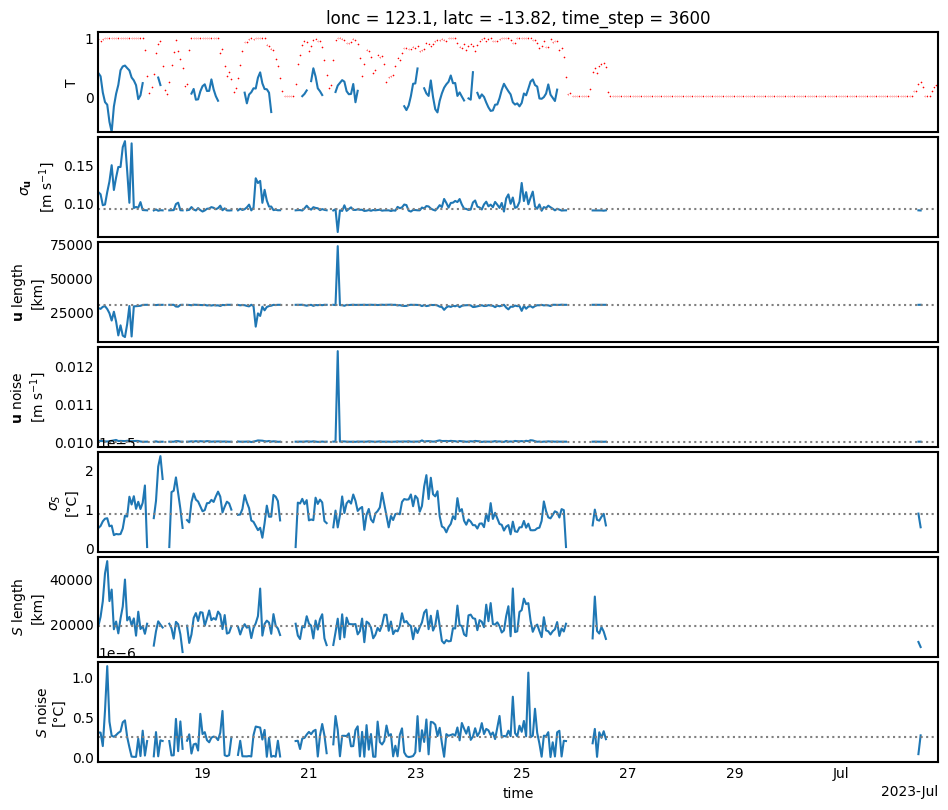

In [17]:
p_vars = ['sigma_u', 'l_u', 'tau_u', 'sigma_S', 'l_S', 'tau_S']
y_labels = ['$\\sigma_{\\mathbf{u}}$\n[m s$^{-1}$]', '$\\mathbf{u}$ length\n[km]', '$\\mathbf{u}$ noise\n[m s$^{-1}$]', '$\\sigma_{S}$\n[°C]', '$S$ length\n[km]', '$S$ noise\n[°C]']

fig, ax = plt.subplots(7, 1, figsize=(10, 10), gridspec_kw={'hspace':0.05})

ds_full_hourly['mu_u'].isel(lon=10, lat=8).plot(ax=ax[0])

good_T = compute_good_data_over_time(ds.sel(time=ds_results.time), 'T')
(good_T).plot.scatter(x='time', ax=ax[0], c='red', s=5, label='Good data fraction')
ax[0].set_xlim(ds_restrim.time[0], ds_restrim.time[-1])
ax[0].set_xticklabels([])
ax[0].set_ylim(-0.6, 1.1)

for ii, var in enumerate(p_vars):
    ds_restrim_hourly[var].plot(ax=ax[ii+1])
    ax[ii+1].plot([ds_restrim.time.values[0], ds_restrim.time.values[-1]], [ds_restrim[var].median(), ds_restrim[var].median()], c='grey', ls=':')
    ax[ii+1].set_ylabel(y_labels[ii])
    ax[ii+1].set_xlim(ds_restrim.time[0], ds_restrim.time[-1])
    if ax[ii+1] != ax[-1]:
        ax[ii+1].set_xticklabels([])
        ax[ii+1].set_xlabel('')

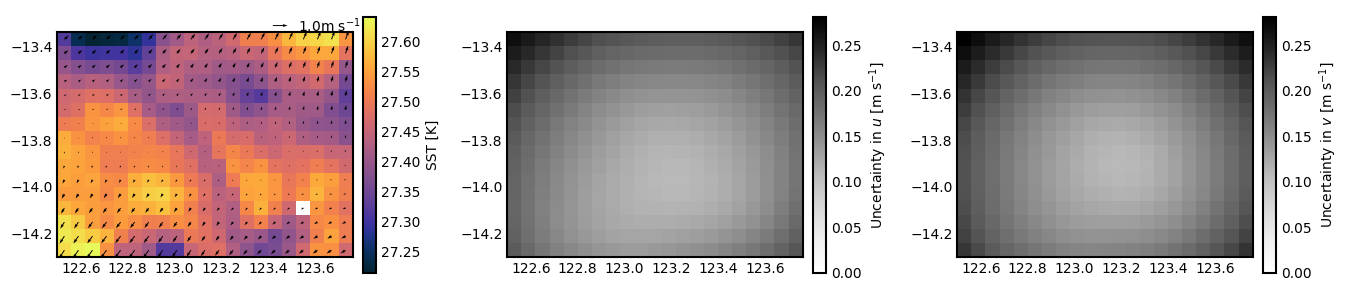

In [ ]:
fig, ax = plots.plot_prediction(ds_full.isel(time=20), qv_scale=20, qk_size=1.)

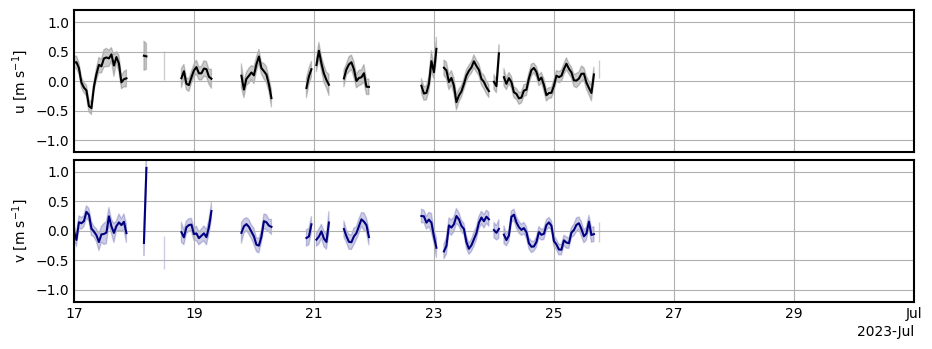

In [ ]:
fig, ax = plots.plot_timeseries(ds_full_hourly, lon_pt=123.3744, lat_pt=-13.74942)
for x in ax:
    x.set_ylim(-1.21,1.21)
    x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[0]) + np.timedelta64(14,'D'))

## Some analysis

In [22]:
import pIMOS.utils.catalogue as pcat

# Load the DWR data
exp = 'Shell'
moor = 'DWR'
exp_base = os.path.join(base_dir, 'Industry', exp, 'data', 'moored_instrument_data')

cat = pcat.get_pimos_catalogue(exp_base, is_moored=True)

# Load the most recent DWR file
ds_dwr = xr.open_dataset(cat['nc_path'].loc[cat['Group']==moor].values[-1], decode_times=True)
ds_dwr

ModuleNotFoundError: No module named 'pIMOS'

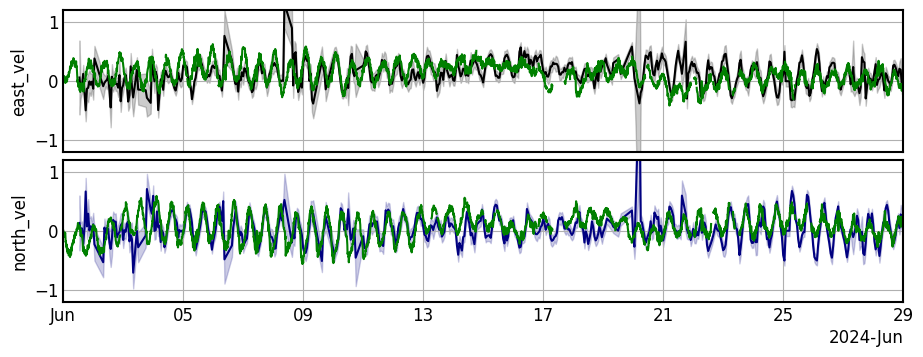

In [ ]:
fig, ax = plots.plot_timeseries(ds_full, lon_pt=123.3744, lat_pt=-13.74942)

ds_dwr['east_vel'].plot(ax=ax[0], c='g')
ds_dwr['north_vel'].plot(ax=ax[1], c='g')

for x in ax:
    x.set_ylim(-1.21,1.21)
    x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[0]) + np.timedelta64(28,'D'))
    x.set_title('')
    x.set_xlabel('')
_=ax[0].set_xticklabels([])

In [ ]:
import pandas as pd
from wootils.filters import check_spacing, filter1d_xr

# Filter the SST inversion data
print(check_spacing(ds_full['time'].values))

# Remove bad fits
ds_full = ds_full.where(np.abs(ds_full['mu_u']) < 1.2)
ds_full = ds_full.where(np.abs(ds_full['mu_v']) < 1.2)

# Fill missing time steps with zero
full_time = pd.date_range(start=ds_full['time'].min().values, end=ds_full['time'].max().values, freq='h')
ds_full = ds_full.reindex({'time': full_time}, fill_value=0)

print(check_spacing(ds_full['time'].values))

ds_full['mu_u_lp'] = filter1d_xr(ds_full['mu_u'].fillna(0), 60, 60, ftype='lowpass', axis=0)
ds_full['mu_v_lp'] = filter1d_xr(ds_full['mu_v'].fillna(0), 60, 60, ftype='lowpass', axis=0)

False
True


In [ ]:
# Apply QC flags
ds_dwr['east_vel'][ds_dwr['qc_velocity']==1] = np.nan
ds_dwr['north_vel'][ds_dwr['qc_velocity']==1] = np.nan

# Filter the DWR data
print(check_spacing(ds_dwr['time'].values))

# Fill missing time steps with zero
full_time = pd.date_range(start=ds_dwr['time'].min().values, end=ds_dwr['time'].max().values, freq='10min')
ds_dwr = ds_dwr.reindex({'time': full_time}, fill_value=0)

print(check_spacing(ds_dwr['time'].values))

ds_dwr['east_vel_lp'] = filter1d_xr(ds_dwr['east_vel'].fillna(0), 60, 10, ftype='lowpass', axis=0)
ds_dwr['north_vel_lp'] = filter1d_xr(ds_dwr['north_vel'].fillna(0), 60, 10, ftype='lowpass', axis=0)

True
True


<>:19: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_25530/258333982.py:19: SyntaxWarning: invalid escape sequence '\o'
  ax[0].set_ylabel('$\overline{u}$ [m s$^{-1}$]')
/tmp/ipykernel_25530/258333982.py:20: SyntaxWarning: invalid escape sequence '\o'
  ax[1].set_ylabel('$\overline{v}$ [m s$^{-1}$]')


Text(0, 0.5, '$\\overline{v}$ [m s$^{-1}$]')

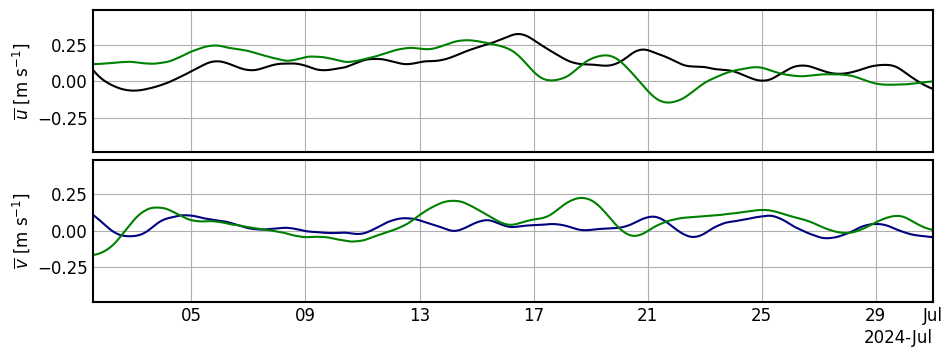

In [ ]:
ds_point = ds_full.sel(lon=123.3744, lat=-13.74942, method='nearest')

fig, ax = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={'hspace':0.05})

ds_point['mu_u_lp'].plot(ax=ax[0], label='u velocity', c='k')
ds_dwr['east_vel_lp'].plot(ax=ax[0], c='g')

ds_point['mu_v_lp'].plot(ax=ax[1], label='v velocity', c='navy')
ds_dwr['north_vel_lp'].plot(ax=ax[1], c='g')

for x in ax:
    x.set_xlabel('')
    x.set_title('')
    x.set_ylim(-0.49, 0.49)
    x.grid()
    x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[0]) + np.timedelta64(28,'D'))

ax[0].set_xticklabels([])
ax[0].set_ylabel('$\overline{u}$ [m s$^{-1}$]')
ax[1].set_ylabel('$\overline{v}$ [m s$^{-1}$]')

In [ ]:
# Load some validation data


: 

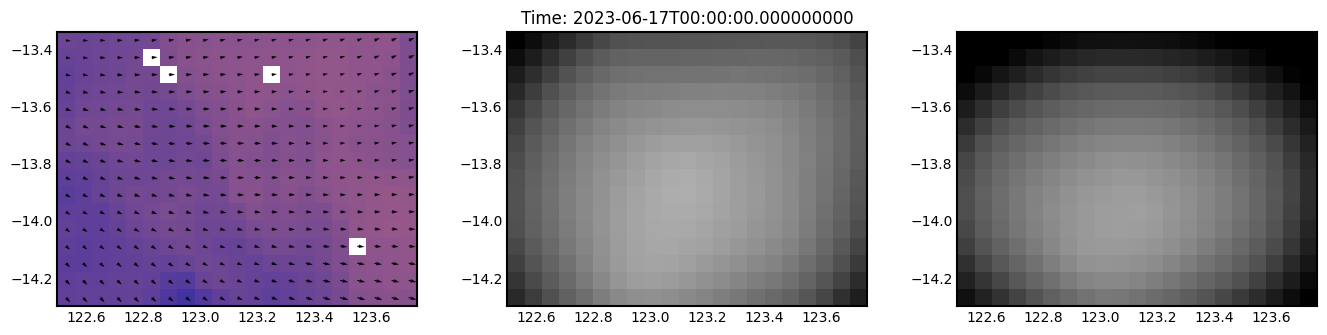

In [26]:
# from IPython.display import HTML
# %matplotlib notebook

ani = plots.plot_prediction_animation(ds_full_hourly, qv_scale=20)
ani.save(f'{crop_app}_animation_full.mp4')
# HTML(ani.to_jshtml())

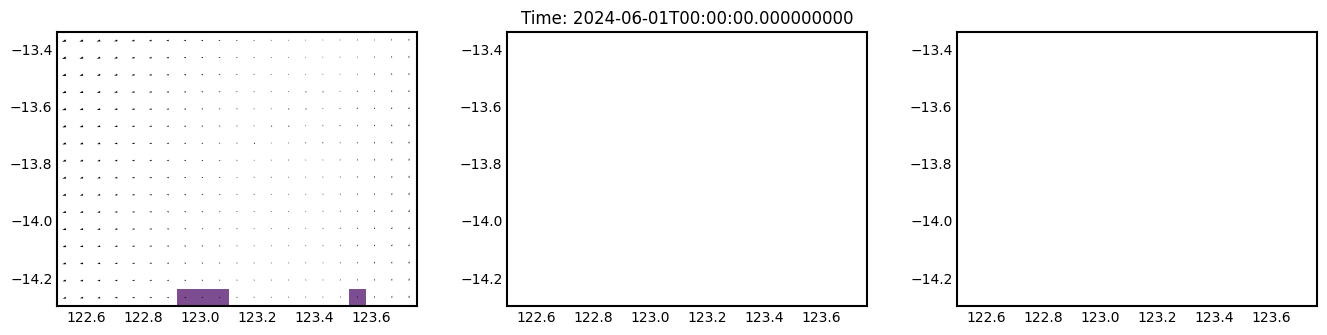

: 

In [ ]:
ani = plots.plot_prediction_animation(ds_full, qv_scale=4, u_name='mu_u_lp', v_name='mu_v_lp', anim_interval=42)
ani.save(f'{crop_app}_animation_lp60hr.mp4')

: 